<h1>Segmenting and Clustering in Toronto</h1>
<h1>Part 1 - Webscrape and load into dataframe</h1>

In [4]:
!conda install -c anaconda beautifulsoup4 --yes


Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.9.0       |           py36_0         165 KB  anaconda
    ca-certificates-2020.1.1   |                0         132 KB  anaconda
    certifi-2020.4.5.1         |           py36_0         159 KB  anaconda
    openssl-1.1.1g             |       h7b6447c_0         3.8 MB  anaconda
    soupsieve-2.0.1            |             py_0          33 KB  anaconda
    ------------------------------------------------------------
                                           Total:         4.3 MB

The following NEW packages will be INSTALLED:

  beautifulsoup4     anaconda/linux-64::beautifulsoup4-4.9.0-py36_0
  soupsieve          anaconda/noarch::soupsieve-2.0.1-py_0

The following packag

In [8]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

In [9]:
List_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(List_url).text

In [13]:
soup = BeautifulSoup(source, 'html.parser')
table=soup.find('table', attrs={'class':'wikitable sortable'})

In [20]:
#dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
column_names = ['Postalcode','Borough','Neighborhood']
df = pd.DataFrame(columns = column_names)

In [21]:
# Search all the postcode, borough, neighborhood 
for tr_cell in table.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==3:
        df.loc[len(df)] = row_data

In [22]:
df.head()

Postalcode           Borough               Neighborhood
0        M1A      Not assigned                           
1        M2A      Not assigned                           
2        M3A        North York                  Parkwoods
3        M4A        North York           Victoria Village
4        M5A  Downtown Toronto  Regent Park, Harbourfront

Remove unassigned rows:

In [24]:
df = df[~df['Borough'].isnull()]  # to filter out bad rows
df.drop(df[df.Borough == 'Not assigned'].index, inplace=True)
df.reset_index(drop=True, inplace=True)
df = df.groupby(['Postalcode','Borough'])['Neighborhood'].apply(lambda x: ','.join(x)).reset_index()
df['Neighborhood'].replace('Not assigned',df['Borough'],inplace=True)
df

Postalcode      Borough                                       Neighborhood
0          M1B  Scarborough                                     Malvern, Rouge
1          M1C  Scarborough             Rouge Hill, Port Union, Highland Creek
2          M1E  Scarborough                  Guildwood, Morningside, West Hill
3          M1G  Scarborough                                             Woburn
4          M1H  Scarborough                                          Cedarbrae
..         ...          ...                                                ...
98         M9N         York                                             Weston
99         M9P    Etobicoke                                          Westmount
100        M9R    Etobicoke  Kingsview Village, St. Phillips, Martin Grove ...
101        M9V    Etobicoke  South Steeles, Silverstone, Humbergate, Jamest...
102        M9W    Etobicoke                Northwest, West Humber - Clairville

[103 rows x 3 columns]

In [26]:
df.shape

(103, 3)

<h1>Part 2 - Get the Lat and Long of the Postal Code Data</h1>

In [27]:
def get_geocode(postal_code):
    # initialize your variable to None
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    return latitude,longitude

In [28]:
geo_df=pd.read_csv('http://cocl.us/Geospatial_data')

In [29]:
geo_df.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

In [31]:
geo_df.rename(columns={'Postal Code':'Postalcode'},inplace=True)
geo_merged = pd.merge(geo_df, df, on='Postalcode')

In [35]:
geo_data=geo_merged[['Postalcode','Borough','Neighborhood','Latitude','Longitude']]

In [36]:
geo_data.head()

Postalcode      Borough                            Neighborhood   Latitude  \
0        M1B  Scarborough                          Malvern, Rouge  43.806686   
1        M1C  Scarborough  Rouge Hill, Port Union, Highland Creek  43.784535   
2        M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3        M1G  Scarborough                                  Woburn  43.770992   
4        M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

<h1>Part 3: Explore and Analyze Toronto</h1>

In [37]:
toronto_data=geo_data[geo_data['Borough'].str.contains("Toronto")]
toronto_data.head()

Postalcode          Borough                    Neighborhood   Latitude  \
37        M4E     East Toronto                     The Beaches  43.676357   
41        M4K     East Toronto    The Danforth West, Riverdale  43.679557   
42        M4L     East Toronto  India Bazaar, The Beaches West  43.668999   
43        M4M     East Toronto                 Studio District  43.659526   
44        M4N  Central Toronto                   Lawrence Park  43.728020   

    Longitude  
37 -79.293031  
41 -79.352188  
42 -79.315572  
43 -79.340923  
44 -79.388790

In [41]:
CLIENT_ID = '43YW...' # your Foursquare ID
CLIENT_SECRET = 'NALU...' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [39]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [40]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West,  Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High

In [42]:
toronto_venues.head()


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  The Beaches              43.676357              -79.293031   
1  The Beaches              43.676357              -79.293031   
2  The Beaches              43.676357              -79.293031   
3  The Beaches              43.676357              -79.293031   
4  The Beaches              43.676357              -79.293031   

                                Venue  Venue Latitude  Venue Longitude  \
0                   Glen Manor Ravine       43.676821       -79.293942   
1  The Big Carrot Natural Food Market       43.678879       -79.297734   
2                 Grover Pub and Grub       43.679181       -79.297215   
3                   Glen Stewart Park       43.675278       -79.294647   
4                       Upper Beaches       43.680563       -79.292869   

      Venue Category  
0              Trail  
1  Health Food Store  
2                Pub  
3               Park  
4       Neighborhood

In [43]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Berczy Park                                                            58   
Brockton, Parkdale Village, Exhibition Place                           23   
Business reply mail Processing Centre, South Ce...                     17   
CN Tower, King and Spadina, Railway Lands, Harb...                     14   
Central Bay Street                                                     62   
Christie                                                               17   
Church and Wellesley                                                   77   
Commerce Court, Victoria Hotel                                        100   
Davisville                                                             33   
Davisville North                                                        7   
Dufferin, Dovercourt Village                                           16   
First Canadian Place, Underground city                                100   
Forest Hill North & West, Forest Hill Road Park                         4   
Garden District, Ryerson                                              100   
Harbourfront East, Union Station, Toronto Islands                     100   
High Park, The Junction South                                          24   
India Bazaar, The Beaches West                                         22   
Kensington Market, Chinatown, Grange Park                              58   
Lawrence Park                                                           3   
Little Portugal, Trinity                                               44   
Moore Park, Summerhill East                                             3   
North Toronto West,  Lawrence Park                                     22   
Parkdale, Roncesvalles                                                 14   
Queen's Park, Ontario Provincial Government                            36   
Regent Park, Harbourfront                                              45   
Richmond, Adelaide, King                                               91   
Rosedale                                                                4   
Roselawn                                                                3   
Runnymede, Swansea                                                     42   
St. James Town                                                         80   
St. James Town, Cabbagetown                                            42   
Stn A PO Boxes                                                         93   
Studio District                                                        41   
Summerhill West, Rathnelly, South Hill, Forest ...                     17   
The Annex, North Midtown, Yorkville                                    22   
The Beaches                                                             6   
The Danforth West, Riverdale                                           42   
Toronto Dominion Centre, Design Exchange                              100   
University of Toronto, Harbord                                         34   

                                                    Neighborhood Longitude  \
Neighborhood                                                                 
Berczy Park                                                             58   
Brockton, Parkdale Village, Exhibition Place                            23   
Business reply mail Processing Centre, South Ce...                      17   
CN Tower, King and Spadina, Railway Lands, Harb...                      14   
Central Bay Street                                                      62   
Christie                                                                17   
Church and Wellesley                                                    77   
Commerce Court, Victoria Hotel                                         100   
Davisville                                                              33   
Davisville North                    

In [44]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.drop(['Neighborhood'],axis=1,inplace=True) 
toronto_onehot.insert(loc=0, column='Neighborhood', value=toronto_venues['Neighborhood'] )
toronto_onehot.shape

(1616, 236)

In [45]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

Neighborhood  Afghan Restaurant  \
0                                        Berczy Park                0.0   
1       Brockton, Parkdale Village, Exhibition Place                0.0   
2  Business reply mail Processing Centre, South C...                0.0   
3  CN Tower, King and Spadina, Railway Lands, Har...                0.0   
4                                 Central Bay Street                0.0   

    Airport  Airport Food Court  Airport Lounge  Airport Service  \
0  0.000000            0.000000        0.000000         0.000000   
1  0.000000            0.000000        0.000000         0.000000   
2  0.000000            0.000000        0.000000         0.000000   
3  0.071429            0.071429        0.142857         0.142857   
4  0.000000            0.000000        0.000000         0.000000   

   Airport Terminal  American Restaurant  Antique Shop  Aquarium  ...  \
0          0.000000                  0.0           0.0       0.0  ...   
1          0.000000                  0.0           0.0       0.0  ...   
2          0.000000                  0.0           0.0       0.0  ...   
3          0.142857                  0.0           0.0       0.0  ...   
4          0.000000                  0.0           0.0       0.0  ...   

   Toy / Game Store  Trail  Train Station  Vegetarian / Vegan Restaurant  \
0               0.0    0.0            0.0                       0.017241   
1               0.0    0.0            0.0                       0.000000   
2               0.0    0.0            0.0                       0.000000   
3               0.0    0.0            0.0                       0.000000   
4               0.0    0.0            0.0                       0.016129   

   Video Game Store  Vietnamese Restaurant  Wine Bar  Wings Joint  \
0               0.0                    0.0  0.000000          0.0   
1               0.0                    0.0  0.000000          0.0   
2               0.0                    0.0  0.000000          0.0   
3               0.0                    0.0  0.000000          0.0   
4               0.0                    0.0  0.016129          0.0   

   Women's Store  Yoga Studio  
0            0.0     0.000000  
1            0.0     0.000000  
2            0.0     0.058824  
3            0.0     0.000000  
4            0.0     0.016129  

[5 rows x 236 columns]

In [46]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [48]:
import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue  \
0                                        Berczy Park           Coffee Shop   
1       Brockton, Parkdale Village, Exhibition Place                  Café   
2  Business reply mail Processing Centre, South C...    Light Rail Station   
3  CN Tower, King and Spadina, Railway Lands, Har...        Airport Lounge   
4                                 Central Bay Street           Coffee Shop   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0          Cocktail Bar                  Café                   Pub   
1        Breakfast Spot             Nightclub           Coffee Shop   
2           Yoga Studio         Auto Workshop            Skate Park   
3       Airport Service      Airport Terminal         Boat or Ferry   
4    Italian Restaurant        Sandwich Place                  Café   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0                  Bakery            Restaurant           Cheese Shop   
1  Furniture / Home Store         Burrito Place    Italian Restaurant   
2                 Brewery                   Spa        Farmers Market   
3         Harbor / Marina      Sculpture Garden                 Plane   
4         Bubble Tea Shop          Burger Joint   Japanese Restaurant   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0              Beer Bar    Seafood Restaurant                 Lounge  
1               Stadium          Intersection             Restaurant  
2  Fast Food Restaurant         Burrito Place                Butcher  
3              Boutique                   Bar     Airport Food Court  
4           Salad Place            Restaurant       Ramen Restaurant

In [50]:
from sklearn.cluster import KMeans
import folium 
from geopy.geocoders import Nominatim 
import matplotlib.cm as cm
import matplotlib.colors as colors

# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [51]:

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

Postalcode          Borough                    Neighborhood   Latitude  \
37        M4E     East Toronto                     The Beaches  43.676357   
41        M4K     East Toronto    The Danforth West, Riverdale  43.679557   
42        M4L     East Toronto  India Bazaar, The Beaches West  43.668999   
43        M4M     East Toronto                 Studio District  43.659526   
44        M4N  Central Toronto                   Lawrence Park  43.728020   

    Longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
37 -79.293031               0                   Pub                  Park   
41 -79.352188               0      Greek Restaurant    Italian Restaurant   
42 -79.315572               0  Fast Food Restaurant        Sandwich Place   
43 -79.340923               0                  Café           Coffee Shop   
44 -79.388790               1                  Park              Bus Line   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
37           Coffee Shop     Health Food Store                 Trail   
41           Coffee Shop            Restaurant        Ice Cream Shop   
42           Pizza Place      Sushi Restaurant            Steakhouse   
43   American Restaurant                Bakery               Brewery   
44           Swim School           Yoga Studio      Department Store   

     6th Most Common Venue 7th Most Common Venue        8th Most Common Venue  \
37             Yoga Studio      Department Store                 Dessert Shop   
41  Furniture / Home Store           Yoga Studio                 Liquor Store   
42          Ice Cream Shop     Fish & Chips Shop                      Brewery   
43               Gastropub           Yoga Studio                  Fish Market   
44    Ethiopian Restaurant     Electronics Store  Eastern European Restaurant   

   9th Most Common Venue 10th Most Common Venue  
37                 Diner         Discount Store  
41                   Spa              Juice Bar  
42     Food & Drink Shop                    Pub  
43           Pizza Place              Pet Store  
44            Donut Shop       Doner Restaurant

In [52]:
neighborhoods_venues_sorted.head()


Cluster Labels                                       Neighborhood  \
0               0                                        Berczy Park   
1               0       Brockton, Parkdale Village, Exhibition Place   
2               0  Business reply mail Processing Centre, South C...   
3               0  CN Tower, King and Spadina, Railway Lands, Har...   
4               0                                 Central Bay Street   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0           Coffee Shop          Cocktail Bar                  Café   
1                  Café        Breakfast Spot             Nightclub   
2    Light Rail Station           Yoga Studio         Auto Workshop   
3        Airport Lounge       Airport Service      Airport Terminal   
4           Coffee Shop    Italian Restaurant        Sandwich Place   

  4th Most Common Venue   5th Most Common Venue 6th Most Common Venue  \
0                   Pub                  Bakery            Restaurant   
1           Coffee Shop  Furniture / Home Store         Burrito Place   
2            Skate Park                 Brewery                   Spa   
3         Boat or Ferry         Harbor / Marina      Sculpture Garden   
4                  Café         Bubble Tea Shop          Burger Joint   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0           Cheese Shop              Beer Bar    Seafood Restaurant   
1    Italian Restaurant               Stadium          Intersection   
2        Farmers Market  Fast Food Restaurant         Burrito Place   
3                 Plane              Boutique                   Bar   
4   Japanese Restaurant           Salad Place            Restaurant   

  10th Most Common Venue  
0                 Lounge  
1             Restaurant  
2                Butcher  
3     Airport Food Court  
4       Ramen Restaurant

In [53]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 43.6534817, -79.3839347.


In [54]:
#Create a map of the clusters
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Screen Shot 2020-05-30 at 4.41.02 PM.png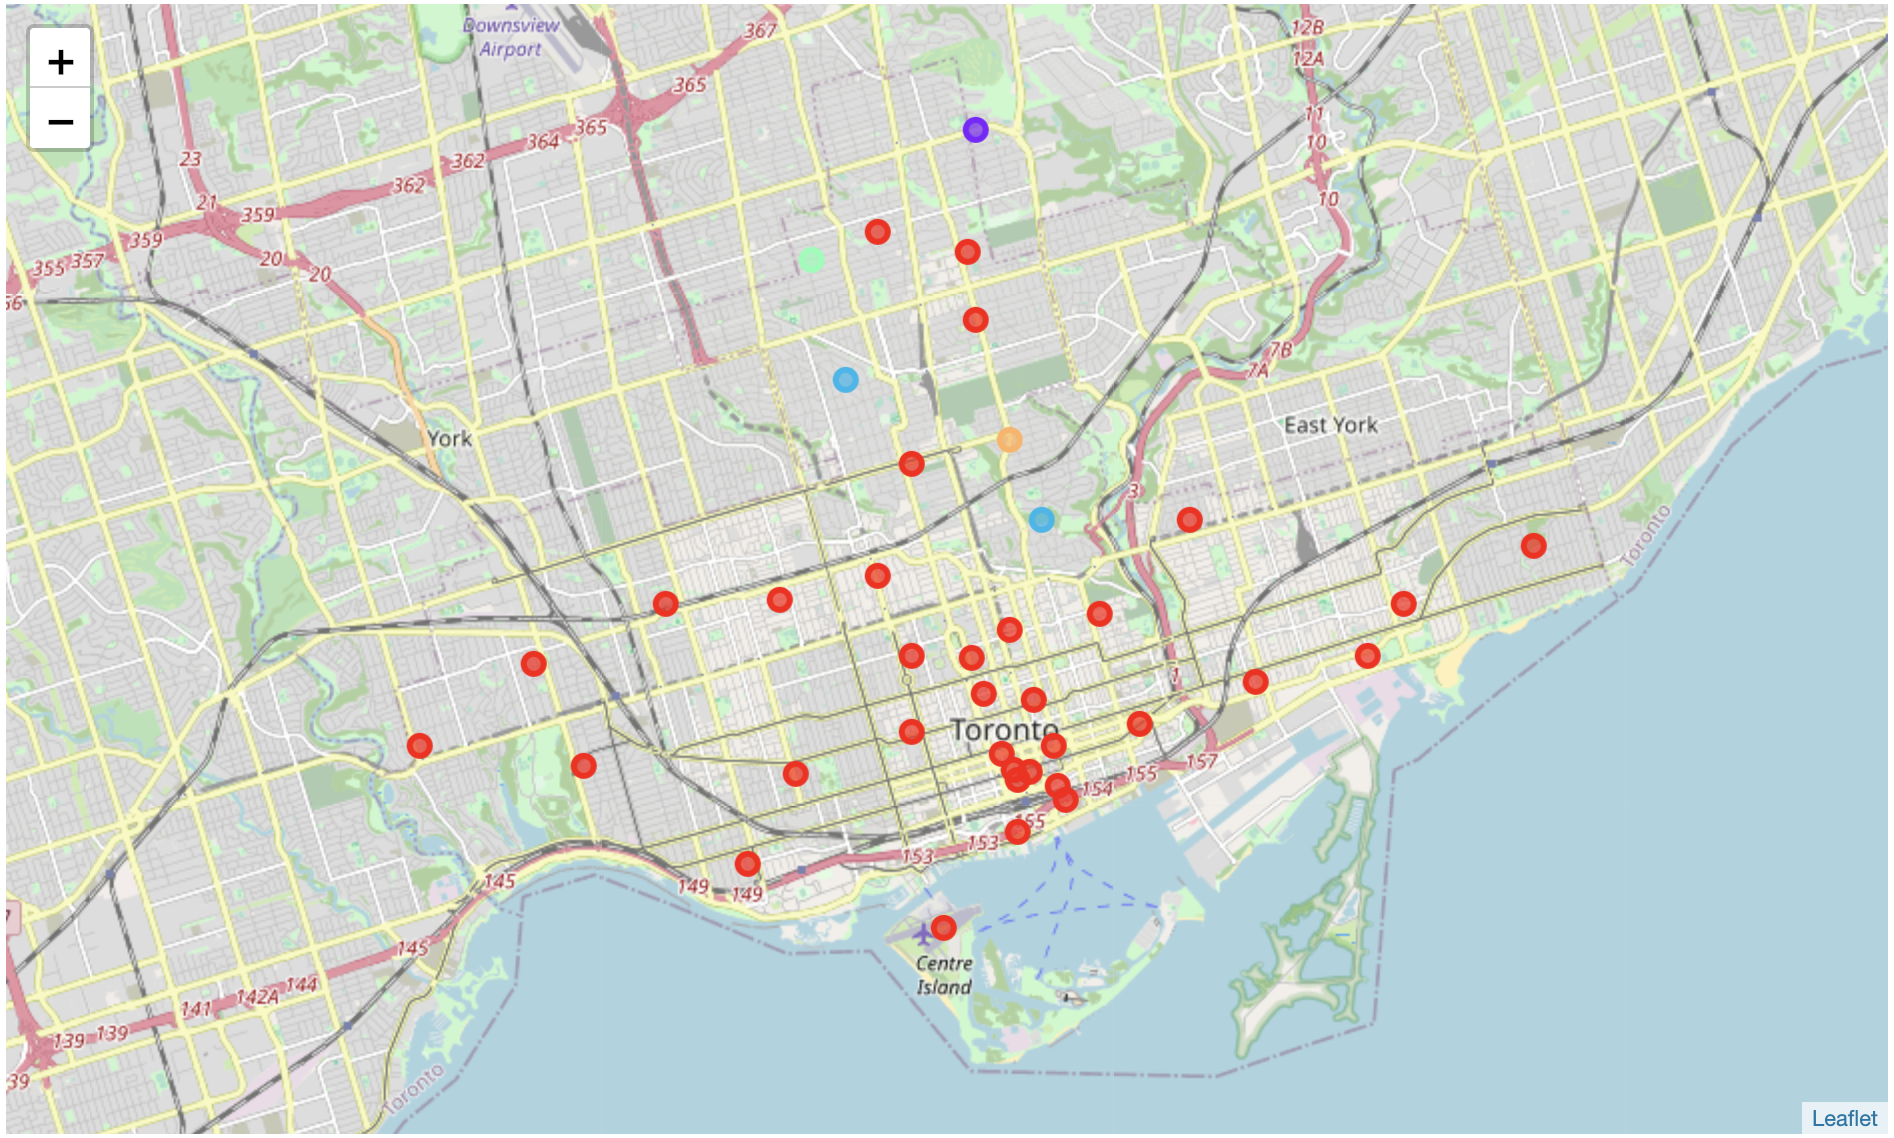